# Combined Cost Analysis

Here comes the fun part. So far, I have collected individual variable price components of the trip. I will now combine all these individual variable and search for the cheapest time to travel for the ski trip. I'm excited!

A brief summary of the trip search details. I'm looking for the cheapest time to go a 5day/4night ski trip to Denver, CO for a possible trave start date between 15th December 2018 and 7th April 2019. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Initiate dataframe withing range of travel start dates
df = pd.DataFrame(data={'date':pd.date_range(start='2018-12-15', end='2019-04-07')})
df['date'] = df['date'].astype(str)

## Airbnb accommodation data
I will add the price of Airbnb listing for a 4-night stay to the travel date DF. But first I filter the Airbnb listings according to my preferences and then add the median price of the remaining listing in the travel data DF. 

### Narrow-down listing according to preferences
I filter the listing according to the following criteria:
1. The number of people a listing accommodates: 2-4 (This would depend on how many people I can convince to join me on the trip).
2. Minimum listing rating of 80.
3. Room type: Entire home/apt

In [4]:
listing = pd.read_csv('../../Data/VacationPlanner/advanced_listing.csv')
idx = ((listing['accommodates'] >= 2) &
       (listing['accommodates'] <= 4) &
       (listing['review_scores_rating'] >= 90) &
       (listing['room_type'] >= 'Entire home/apt'))

selected_listing_id = listing[idx]['id']
listing = listing.set_index('id')

### Narrow down calendar price data to selected listing id

In [5]:
calendar = pd.read_csv('../../Data/VacationPlanner/advanced_calendar.csv')
calendar = calendar[calendar['id'].isin(selected_listing_id)]
calendar.head()
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121404 entries, 151 to 262739
Data columns (total 4 columns):
Unnamed: 0    121404 non-null int64
id            121404 non-null int64
date          121404 non-null object
price         111671 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.6+ MB


### Compile total median Airbnb cost 

For each start date between 15th December 2018 and 7th April 2019, I compile the total median cost of all the listing in which I could potentially stay for 4 consecutive nights,and then add this data to the travel date DF. 


In [6]:
def median_airbnb_cost(start_date):
    
    # Find end date
    df_ = pd.DataFrame(data={'date':pd.date_range(start=start_date, periods=4)})
    end_date = df_['date'].astype(str).tolist()[-1]
    
    # Collect all listing between start and end date
    sub_calendar = calendar[(calendar['date'] >= start_date) &
                           (calendar['date'] <= end_date)]
    
    # Find listings which are not available for all the 4 nights
    invalid_id = sub_calendar[sub_calendar['price'].isnull()]['id'].unique()
    
    # Sum of price to stay at a listing
    df_local = sub_calendar.groupby('id').sum()
    
    # Remove invalid id
    df_local = df_local[~df_local.index.isin(invalid_id)]
    
    # Compure price person for the valid listings
    df_local['id'] = df_local.index
    df_local.reset_index(drop=True)
    df_local['cleaning_fee'] = df_local['id'].apply(lambda x: listing.loc[x, 'cleaning_fee'])
    df_local['accommodates'] = df_local['id'].apply(lambda x: listing.loc[x, 'accommodates'])
    df_local['price'] = (df_local['price'] + df_local['cleaning_fee'])/df_local['accommodates']
    
    return df_local['price'].median()

# Collect Airbnb cost in travel data DF
df['Airbnb_cost'] = df['date'].apply(median_airbnb_cost)

df.head()

,date,Airbnb_cost
0,2018-12-15,148.333333
1,2018-12-16,147.250000
2,2018-12-17,147.000000
3,2018-12-18,147.500000
4,2018-12-19,150.000000


## Flight price data
To travel data DF, I add the flight price data for the given start date and a 4 night from origin airport from Madison and Chicago. 

In [7]:
flight_price = pd.read_csv('../../Data/VacationPlanner/flight_price.csv')
flight_price = flight_price.set_index('date')

df['fly_Madison'] = df['date'].apply(lambda x: flight_price.loc[x, 'Madison'])
df['fly_Chicago'] = df['date'].apply(lambda x: flight_price.loc[x, 'Chicago'])

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago
0,2018-12-15,148.333333,261.0,277.0
1,2018-12-16,147.250000,267.0,312.0
2,2018-12-17,147.000000,415.0,305.0
3,2018-12-18,147.500000,261.0,332.0
4,2018-12-19,150.000000,381.0,287.0


## Secondary costs

Secondary cost comprises of combined two variable costs: (1) vacation day cost and (2) peak travel day cost. Here, I add the total secondary cost for the five days spent in the ski trip to the travel date DF. 

In [8]:
vacationday_peaktravel = pd.read_csv('../../Data/VacationPlanner/peaktravel_vacationday_cost.csv')
vacationday_peaktravel = vacationday_peaktravel.set_index('date')

def cumulative_cost(start_date):
    
    # Find end date
    df_ = pd.DataFrame(data={'date':pd.date_range(start=start_date, periods=5)})
    end_date = df_['date'].astype(str).tolist()[-1]
    
    # Slice all cost between start and end date
    sub_df = vacationday_peaktravel.loc[start_date:end_date, ['vacation_day_cost', 'peak_travel_cost']]
    
    return sub_df.sum().sum()

df['secondary_cost'] = df['date'].apply(cumulative_cost)

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago,secondary_cost
0,2018-12-15,148.333333,261.0,277.0,230
1,2018-12-16,147.250000,267.0,312.0,285
2,2018-12-17,147.000000,415.0,305.0,340
3,2018-12-18,147.500000,261.0,332.0,345
4,2018-12-19,150.000000,381.0,287.0,350


## Weather data

Collect and add the snowdepth data to the the travel date DF.

In [9]:
weather = pd.read_csv('../../Data/VacationPlanner/weather_trend.csv')
weather = weather.set_index('date')

df['snwd'] = df['date'].apply(lambda x: weather.loc[x, 'SNWD'])
# df['temp'] = df['date'].apply(lambda x: weather.loc[x, 'TAVG'])
df['snwd_std'] = df['date'].apply(lambda x: weather.loc[x, 'SNWD_STD'])
# df['temp_std'] = df['date'].apply(lambda x: weather.loc[x, 'TAVG_STD'])

df.head()

,date,Airbnb_cost,fly_Madison,fly_Chicago,secondary_cost,snwd,snwd_std
0,2018-12-15,148.333333,261.0,277.0,230,12.275755,6.828423
1,2018-12-16,147.250000,267.0,312.0,285,12.834855,8.253375
2,2018-12-17,147.000000,415.0,305.0,340,13.236365,8.451981
3,2018-12-18,147.500000,261.0,332.0,345,13.623114,8.662577
4,2018-12-19,150.000000,381.0,287.0,350,14.000591,8.825957


## Total cost to fly from Madison or Chicago

Compute the total variable cost to fly from either Madison or Chicago by adding the variable flight ticket price, secondary costs and Airbnb cost. 

In [10]:
df['Madison'] = df['fly_Madison'] + df['secondary_cost'] + df['Airbnb_cost']
df['Chicago'] = df['fly_Chicago'] + df['secondary_cost'] + df['Airbnb_cost']

## Find the cheapest travel start date

Cheapest travel date to fly from both Madison and Chicago. And also look at the individual cost components

In [28]:
cheapest_price = df[['Madison', 'Chicago']].min().min()
cheapest_price

513.0

In [29]:
# Cheapest price and date details from Chicago
df.loc[df['Chicago'].idxmin()]

date              2019-02-02
Airbnb_cost              151
fly_Madison              162
fly_Chicago              190
secondary_cost           200
snwd                 29.6037
snwd_std              11.053
Madison                  513
Chicago                  541
Name: 49, dtype: object

In [30]:
# Cheapest price and date details from Madison
df.loc[df['Madison'].idxmin()]

date              2019-02-02
Airbnb_cost              151
fly_Madison              162
fly_Chicago              190
secondary_cost           200
snwd                 29.6037
snwd_std              11.053
Madison                  513
Chicago                  541
Name: 49, dtype: object

# Visualize

Visualize the total and individual variable cost components for the range of start date to find the cheapest time to travel. In the plot, I also have the snow depth data to see if the cheapest time to travel will have good snow conditions. 

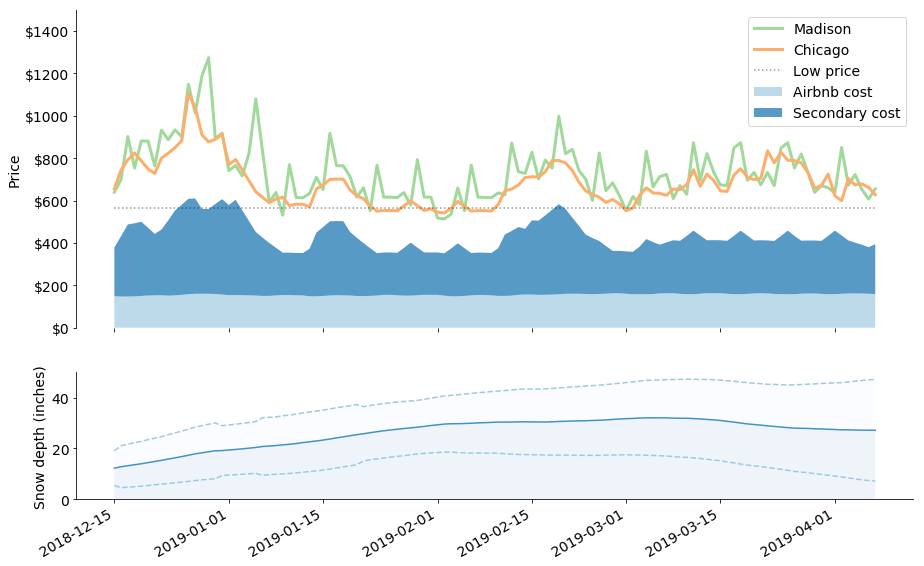

In [34]:
fig, ax = plt.subplots(2,1, sharex=True, figsize = (15,10),
                        gridspec_kw = {'height_ratios':[3, 1.2]})
plt.rcParams.update({'font.size': 14})

# First subplot has stacked price cost for line plot for flight ticket from Madison and Chicago
labels = ["Airbnb cost", "Secondary cost"]
colors = ['#a6cee3', '#1f78b4']

ax[0].stackplot(df['date'], 
                df['Airbnb_cost'],
                df['secondary_cost'],
                labels=labels,
                colors=colors, 
                alpha=0.75)
ax[0].plot(df['date'], df['Madison'], 'k', color='#a1d99b', linewidth=3)
ax[0].plot(df['date'], df['Chicago'], 'k', color='#fdae6b', linewidth=3)
ax[0].plot(df['date'], 0*df['Madison']+cheapest_price+50, ':k', alpha=0.4, label='Low price')
ax[0].legend(fontsize=14, loc='upper right')
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].set_yticklabels(['${0:0.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Price', fontdict={'size':14})
ax[0].set_ylim(0,1500)

# Draw snowdepth plot
lower = df['snwd'] - df['snwd_std']
lower[lower<0] = 0
upper = df['snwd'] + df['snwd_std']
ax[1].fill_between(df['date'], lower*0, df['snwd'],
            alpha=0.5, facecolor='#deebf7')
ax[1].fill_between(df['date'], df['snwd'], upper,
            alpha=0.5, facecolor='#f7fbff')
ax[1].plot(df['date'], lower, '--', color='#9ecae1')
ax[1].plot(df['date'], upper, '--', color='#9ecae1')
ax[1].plot(df['date'], df['snwd'], 'k', color='#4292c6')
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_ylabel('Snow depth (inches)', fontdict={'size':14});
ax[1].set_ylim(0,50)

xticks = ['2018-12-15', '2019-01-01', '2019-01-15', '2019-02-01', '2019-02-15', '2019-03-01', 
          '2019-03-15', '2019-04-01']
ax[1].set_xticks(xticks)

fig.autofmt_xdate()

# Conclusion

## Cheapest time to travel

**The cheapest time to travel is 2nd February 2019 with flight from Maidson and a total variable price of $513.** Some later days with tickets from Madison are also quite cheap. This gives me some flexibility.

Couple other time when tickets get close to this range is the second week of January and last week February. The good news is that the cheapest travel dates have flights from Madison. Meaning I don't have to take a bus to Chicago to catch a flight. 

In [37]:
df.loc[df['Madison'].idxmin()]

date              2019-02-02
Airbnb_cost              151
fly_Madison              162
fly_Chicago              190
secondary_cost           200
snwd                 29.6037
snwd_std              11.053
Madison                  513
Chicago                  541
Name: 49, dtype: object

## Saving from this optimization

Now that I have already done the optimization to select the best travel data. Now, I want to check if this optimization was worth the effort.

I measure this in two ways:
#### (1) Mean Cost savings:
The amount of money saved between traveling on a random date. I assume this can be represented well by the mean cost over all the travel date range. With optimization, I save approximately **$221.83**. This is a big saving for me.

In [47]:
# Mean Saving
df['Madison'].mean() - df['Madison'].min()

221.83260233918122

#### (2) Worst case savings:
The amount of money saved between the worst and the best date to travel is **$761**. 

In [46]:
# Worst case Saving
df['Madison'].max() - df['Madison'].min()

761.0

## Approximating best time to travel by optimizing only on flight tickets

An often suggested budget travel trip is to find the cheapest day for air tickets to reduce travel cost. 

I want to test this hypothesis and see if optimizing only on flight ticket is a good approximation for finding the cheapest dates to travel.


#### Correlation between flight price and total price

The correlation value of 0.83, suggests that their does exist a strong correlation between flight price and total cost. So flight price could a good approximation.

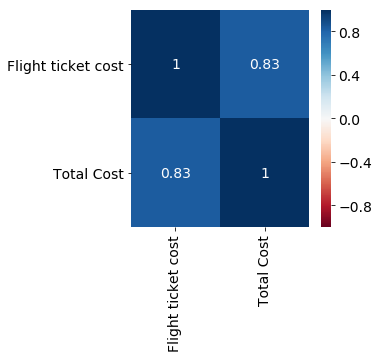

In [58]:
corrmat = (df[['fly_Madison', 'Madison']].corr().values + df[['fly_Chicago', 'Chicago']].corr().values)/2
plt.figure(figsize=(4,4))
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='RdBu',
            xticklabels=['Flight ticket cost', 'Total Cost'],
           yticklabels=['Flight ticket cost', 'Total Cost']);

#### Lost saving when optimizing only on flight price

We just saw that flight price and total price have strong correlation. Now, we make a comparison on how much potentially saving that I would not be taking advatnage of if I was only optimizing on flight price. 

To quantity this, I search for 7 cheapests dates of travel based on only flight price and total travel cost. Then, I find the mean difference between cost of travels on these dates. 

In [74]:
# Will only focus on Madison data

num_days = 7 # N number of cheapest travel dates to consider

# Mean travel cost on 7 cheapest days to travel based only on flight price 
mean_travel_onlyflight =  df.sort_values(['fly_Madison'], ascending=1)[:num_days]['Madison'].mean()

# Mean travel cost on 7 cheapest days to travel based on totral travel cost 
mean_travel_totalcost =  df.sort_values(['Madison'], ascending=1)[:num_days]['Madison'].mean()

# Savings lost if I only optimize on flight price
savings_lost = mean_travel_onlyflight - mean_travel_totalcost
savings_lost
print('Potential mean savings lost: ${:0.2f}'.format(savings_lost))

Potential mean savings lost: $90.75


On average if I only optimize only based on flight tickets, I would lose on average \$90.75. That is a significant number.

In all, I would say this excercise was worth the effort. And I can pretty much use this same infrastructure to optimize on my other vacations in future. This was fun :D